In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

 Activating environment at `~/Research/PISNMassFunctions/Project.toml`


Load some modules:

In [9]:
using LaTeXStrings
using PISNMassFunctions
using StatsFuns
using StatsPlots

It's too bad, because they look pretty, but Safari slows to a crawl with SVG graphics, so we need to set PNG:

In [4]:
default(:png)

missing

Many of the functions used to construct the mass distribution have "ramps" or turn-ons/turn-offs; I use a logistic function for this, scaled to have unit slope at the origin.  For example, power-law breaks are constructed by summing two power laws multiplied by turn ons and turn offs.  The nice thing about the logistic function is that 
$$
f\left(x\right) + f\left(-x\right) = 1
$$
for all $x$.

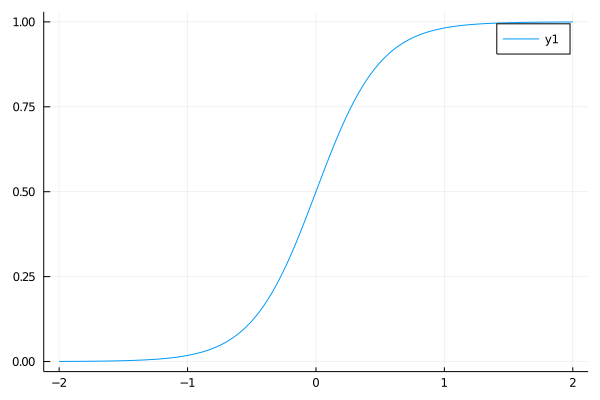

In [5]:
x = -2.0:0.01:2.0
plot(x, exp.(PISNMassFunctions.log_logistic_unit.(x)))

My model assumes that the CO core mass function is broken power law with the break at $m_\mathrm{CO} = 15 M_\odot$.  The break "isolates" the low-mass behavior of the mass distribution from the high-mass behavior, and has *some* support in literature; see, e.g., [Schneider, et al. (2018)](https://arxiv.org/abs/1801.03107) or [Farr & Mandel (2018)](https://arxiv.org/abs/1807.09772).

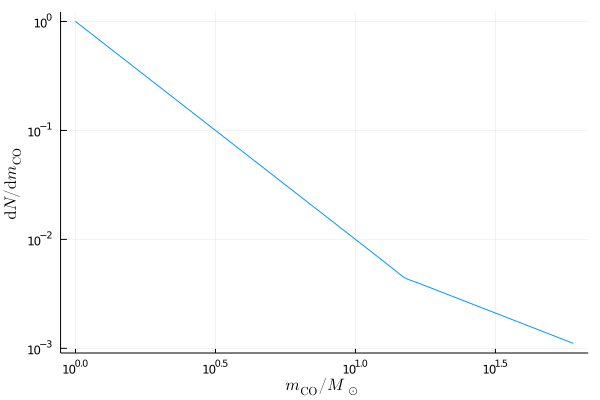

In [10]:
m = 1.0:0.01:60.0
plot(m, exp.(PISNMassFunctions.log_dNdmCO.(m, 2.0, 1.0)), yscale=:log10, xscale=:log10, legend=nothing)
xlabel!(L"m_\mathrm{CO} / M_\odot")
ylabel!(L"\mathrm{d} N / \mathrm{d} m_\mathrm{CO}")

We imagine that the secondary CO core mass follows a power law in the mass ratio.  (This is a common assumption about the secondary mass in binaries.)  Note that there is no break in this power law.  

In [11]:
qs = collect(0.01:0.01:1.0)
plot(qs, exp.(PISNMassFunctions.log_dNdqCO.(qs, 2.3)), legend=nothing)
xlabel!(L"q")
ylabel!(L"\mathrm{d} N / \mathrm{d} q")

Now, by analogy to the [Farmer, et al. (2019)](http://arxiv.org/abs/1910.12874) model, we suppose that the *mean* black hole mass follows a linear relation up to some "PPISN onset," and a quadratic one beyond that.  In a useful parameterization:
$$
m_\mathrm{BH} = \begin{cases}
m_\mathrm{CO} + 4 & m_\mathrm{BH} < m_\mathrm{PISN} \\
m_\mathrm{BH,max} - a \left( m_\mathrm{CO} - m_\mathrm{CO,max} \right)^2 & m_\mathrm{BH} > m_\mathrm{PISN}
\end{cases}
$$
with
$$
a = \frac{1}{4\left( m_\mathrm{BH,max} - m_\mathrm{PISN} \right)}
$$
and
$$
m_\mathrm{CO,max} = 2 m_\mathrm{BH,max} - m_\mathrm{PISN} - 4
$$
This parameterization ensures that the relation is smooth at $m = m_\mathrm{PISN}$ where the pulsations begin.

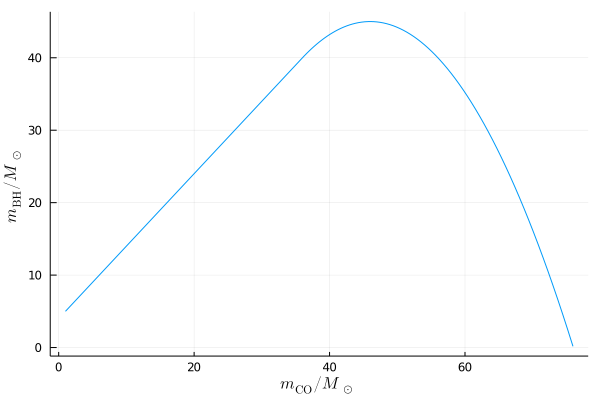

In [12]:
let mPISN = 40.0, mBH_max = 45.0
    mcm = PISNMassFunctions.max_CO_mass(mPISN, mBH_max)
    mcs = exp.(log(1):0.01:log(mcm))
    plot(mcs, PISNMassFunctions.mean_mBH_of_mCO.(mcs, mPISN, mBH_max), legend=nothing)
    xlabel!(L"m_\mathrm{CO} / M_\odot")
    ylabel!(L"m_\mathrm{BH} / M_\odot")
end

We will introduce some amount of "scatter" in the black hole mass at fixed CO core mass by modelling the BH mass as drawn from a normal distribution with a width $\sigma \sim 1 \, M_\odot$ around the mean relation described above:

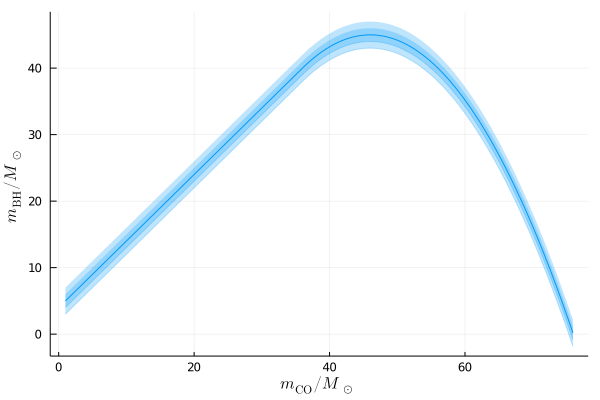

In [13]:
let mPISN = 40.0, mBH_max = 45.0, sigma = 1.0
    mcm = PISNMassFunctions.max_CO_mass(mPISN, mBH_max)
    mcs = exp.(log(1):0.01:log(mcm))
    plot(mcs, PISNMassFunctions.mean_mBH_of_mCO.(mcs, mPISN, mBH_max), legend=nothing)
    plot!(mcs, PISNMassFunctions.mean_mBH_of_mCO.(mcs, mPISN, mBH_max).-sigma, fillrange=PISNMassFunctions.mean_mBH_of_mCO.(mcs, mPISN, mBH_max).+sigma, alpha=0.25, color=1)
    plot!(mcs, PISNMassFunctions.mean_mBH_of_mCO.(mcs, mPISN, mBH_max).-2 .* sigma, fillrange=PISNMassFunctions.mean_mBH_of_mCO.(mcs, mPISN, mBH_max).+ 2 .*sigma, alpha=0.25, color=1)
    xlabel!(L"m_\mathrm{CO} / M_\odot")
    ylabel!(L"m_\mathrm{BH} / M_\odot")
end

If the mapping between CO core mass and BH mass were completely deterministic, the vanishing of the derivative as $m_\mathrm{CO} \to m_{\mathrm{CO},max}$ would lead to an integrable singularity in the BH mass distribution (provided the density of CO core masses does not vanish; which our broken power law does not).  However, we would not expect the relationship to be perfectly deterministic because (a) it will vary---perhaps weakly---with the intrinsic properties of the stars like metallicity and (b) there is an element of randomness in the number and strength of pulsations that drive the mass loss for sufficiently massive cores.

We can model this by giving $m_\mathrm{BH}$ a distribution of finite width around the value predicted by the core mass--black hole mass relation.  For simplicity, we choose this to be a normal distribution with width $\sigma$:
$$
p\left( m_\mathrm{BH} \mid m_\mathrm{CO} \right) = N\left[ m_\mathrm{BH}\left( M_\mathrm{CO} \right), \sigma \right] \left( m_\mathrm{BH} \right).
$$
In *our* analysis, $\sigma$ is a parameter but does not vary with redshift, mass, etc; but it would be straightforward to fit a varying width with any of these properties of the BBH system to account for point (a) above.

With this choice, we have
$$
\frac{\mathrm{d} N}{\mathrm{d} m_\mathrm{BH} } = \int \mathrm{d} m_\mathrm{CO} \, p\left( m_\mathrm{BH} \mid m_\mathrm{CO} \right) \frac{\mathrm{d} N}{\mathrm{d} m_\mathrm{CO}}.
$$

If we assume that the Gaussian is sufficiently narrow compared to both the scale on which $\mathrm{d}N/\mathrm{d} m_\mathrm{CO}$ varies and the curvature scale of the core mass--black hole mass relation (i.e. $\sigma \ll m_\mathrm{BH,max} - m_\mathrm{PISN}$), then the contribution to the integral will be dominated by $m_\mathrm{CO}$ near the two values that give the appropriate $m_\mathrm{BH}$ (a glance at the above plot shows that there are always two such values for any $0 < m_\mathrm{BH} < m_\mathrm{BH,max}$).  We can use a modified method of stationary phase to evaluate the exponential integral (modified because the exponential is *quartic* in $m_\mathrm{CO}$).

For $m_\mathrm{BH} < m_\mathrm{PISN}$, one of the $m_\mathrm{CO}$ values comes from the linear relationship, and the other from the quadratic; for $m_\mathrm{PISN} < m_\mathrm{BH} < m_\mathrm{BH,max}$ both values come from the quadratic part of the relation.  For $m_\mathrm{BH,max} < m_\mathrm{BH}$ the values are degenerate (i.e. there is a double root at $m_\mathrm{CO} = m_\mathrm{CO,max}$).  Each value of $\mathrm{d} N/\mathrm{d} m_\mathrm{CO}$ is weighted by the integral of the Gaussian over all $m_\mathrm{CO}$ (or, for the quadratic, half this integral, since the integrand will have two peaks of equal weight, corresponding to the two solutions for $m_\mathrm{CO}\left( m_\mathrm{BH} \right)$).

The integral over the Gaussian in the linear region is straightforward:
$$
\left. \frac{\mathrm{d} N}{\mathrm{d} m_\mathrm{BH}} \right|_\mathrm{linear} = \left. \frac{\mathrm{d} N}{\mathrm{d} m_\mathrm{CO}} \right|_{m_\mathrm{CO} = m_\mathrm{BH} - 4 \, M_\odot} \int \mathrm{d} m_\mathrm{CO} \, \frac{1}{\sigma \sqrt{2 \pi}} \exp\left[ -\frac{\left( m_\mathrm{BH} - \left( 4 \, M_\odot + m_\mathrm{CO} \right) \right)^2}{2 \sigma^2} \right] = \left. \frac{\mathrm{d} N}{\mathrm{d} m_\mathrm{CO}} \right|_{m_\mathrm{CO} = m_\mathrm{BH} - 4 \, M_\odot}.
$$

In the quadratic regime the integral is a bit trickier (thanks, Mathematica!).  Each of the quadratic terms is 
$$
\left. \frac{\mathrm{d} N}{\mathrm{d} m_\mathrm{BH}} \right|_\mathrm{quad} = \frac{1}{2} \left. \frac{\mathrm{d} N}{\mathrm{d} m_\mathrm{CO}} \right|_{m_\mathrm{CO} = m_{\mathrm{CO}, \pm}} \int \mathrm{d} m_\mathrm{CO} \, \frac{1}{\sigma \sqrt{2 \pi}} \exp\left[ - \frac{\left( m_\mathrm{BH} - \left( m_\mathrm{BH,max} - c \left( m_\mathrm{CO} - m_\mathrm{CO,max} \right)^2 \right) \right)^2}{2 \sigma^2} \right],
$$
where 
$$
m_\mathrm{\mathrm{CO},\pm} = \begin{cases}
m_{\mathrm{CO,max}} \pm \sqrt{\frac{m_\mathrm{BH,max} - m_\mathrm{BH}}{a}} & m_\mathrm{BH} < m_\mathrm{BH,max} \\
m_\mathrm{CO,max} & m_\mathrm{BH} \geq m_\mathrm{BH,max}
\end{cases}
$$
The integral becomes
$$
\frac{1}{2 \sqrt{c \sigma} } \exp\left[ - \frac{\left( m_\mathrm{BH} - m_\mathrm{BH,max} \right)^2}{4 \sigma^2} \right] \begin{cases}
\sqrt{\frac{\pi}{2}} \sqrt{\frac{m_\mathrm{BH,max} - m_\mathrm{BH}}{\sigma}} \left( I_{-1/4}\left( \frac{\left( m_\mathrm{BH,max} - m_\mathrm{BH} \right)^2}{4 \sigma^2} \right) + I_{1/4}\left( \frac{\left( m_\mathrm{BH,max} - m_\mathrm{BH} \right)^2}{4 \sigma^2} \right) \right) & m_\mathrm{BH} < m_\mathrm{BH,max} \\
\frac{1}{\sqrt{\pi}} \sqrt{\frac{m_\mathrm{BH} - m_\mathrm{BH,max}}{\sigma}} K_{1/4}\left(\frac{\left( m_\mathrm{BH} - m_\mathrm{BH,max} \right)^2}{4 \sigma^2} \right) & m_\mathrm{BH} > m_\mathrm{BH,max}
\end{cases}
$$
Where $I$ and $K$ are modified Bessel functions of the first and second kind.  Though it doesn't look it, the piecewise-defined function above is actually analytic across $m_\mathrm{BH,max}$.

Effectively, we are implementing the "stationary phase" approximation to this exponential integral (i.e. we are looking for the stationary points of the argument of the Gaussian); but things are a bit more complicated in this setting because in the quadratic part of the fit the Gaussian argument is a quadratic in $m_\mathrm{CO}^2$ (that is, it contains even powers up to 4).  So the "stationary point" at $m_\mathrm{BH} = m_\mathrm{BH,max}$ is actually a *degenerate* stationary point where the curvature *also* vanishes, so we cannot use the usual stationary phase tricks, but ended up with these funky Bessel functions. 

There is a minor discontinuity at $m_\mathrm{PISN}$ because the quartic integral does not quite match the quadratic integral where the linear and quadratic $m_\mathrm{BH}$--$m_\mathrm{CO}$ relations match up---but as long as $m_\mathrm{BH,max} - m_\mathrm{PISN} \gg \sigma$, this discontinuity is small.

Because we assume that there is a joint distribution on $m_{\mathrm{CO},1}$ and $q_{\mathrm{CO}}$ for a given pair of BH masses $m_1$ and $m_2 = q m_1$, we need to consider *four* pairs of CO masses based on which "branch" of the core mass--black hole mass relation gives the associated core masess (both on the *left* branch; $m_1$ from the left, $m_2$ from the right; $m_1$ from the right, $m_2$ from the left; and both on the right).

The density is coded in `src/model.jl`, and includes series expansions to avoid overflow when $m_\mathrm{BH}$ becomes large and overflow in the derivative near $m_\mathrm{BH,max}$.

Below we plot the implied $\mathrm{d}N/\mathrm{d}m_\mathrm{BH}$ for various mass ratios and modest $\sigma$.  As $\sigma \to 0$ the height of the "bump" diverges at $m_\mathrm{BH,max}$; the width of the bump is controlled by the difference between the point of onset of the pulsations, $m_\mathrm{BH} = m_\mathrm{PISN}$, and the maximum black hole mass.  Recall that we must limit $\sigma \ll m_\mathrm{BH,max} - m_\mathrm{PISN}$ for the stationary phase approximation above to be reasonable.

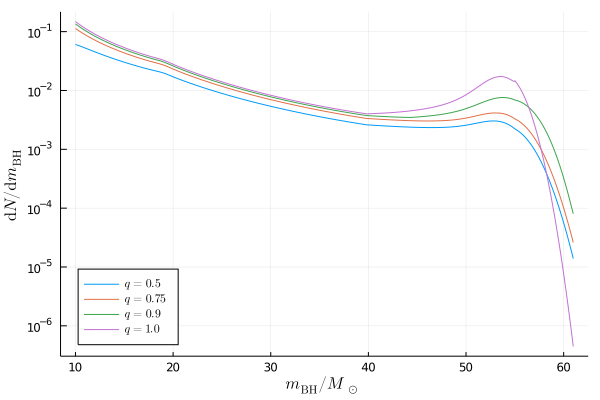

In [14]:
let mPISN = 40.0, mBH_max = 55.0, sigma = 2.0, a = 1.35, b = 2.35, beta=0.5
    mbhs = exp.(log(10.0):0.001:log(mBH_max+3*sigma)) .+ 1e-12
    plot(mbhs, exp.(PISNMassFunctions.log_dNdm1dq_stellar.(mbhs, 0.5, a, b, beta, mPISN, mBH_max, sigma)), label=L"q = 0.5", yscale=:log10, legend=:bottomleft)
    plot!(mbhs, exp.(PISNMassFunctions.log_dNdm1dq_stellar.(mbhs, 0.75, a, b, beta, mPISN, mBH_max, sigma)), label=L"q = 0.75", yscale=:log10)
    plot!(mbhs, exp.(PISNMassFunctions.log_dNdm1dq_stellar.(mbhs, 0.9, a, b, beta, mPISN, mBH_max, sigma)), label=L"q = 0.9", yscale=:log10)
    plot!(mbhs, exp.(PISNMassFunctions.log_dNdm1dq_stellar.(mbhs, 1.0, a, b, beta, mPISN, mBH_max, sigma)), label=L"q = 1.0", yscale=:log10)
    xlabel!(L"m_\mathrm{BH} / M_\odot")
    ylabel!(L"\mathrm{d}N/\mathrm{d} m_\mathrm{BH}")
end

In addition to this power law from stellar BH formation, we include a second power law with exponent $c$ in the BH mass distribution (note the low-mass power law is applied to the core mass distribution, not the BH mass!).  This high-mass power law has a relative amplitude at $m_\mathrm{PISN}$ that is a fraction $f$ of the "stellar" power law.  It is meant to capture non-stellar origin BHs above the high-mass cutoff (e.g. GW190521).  Together with the primary mass power law, we also introduce a parameter for the BH mass ratio when the primary is at these high masses.

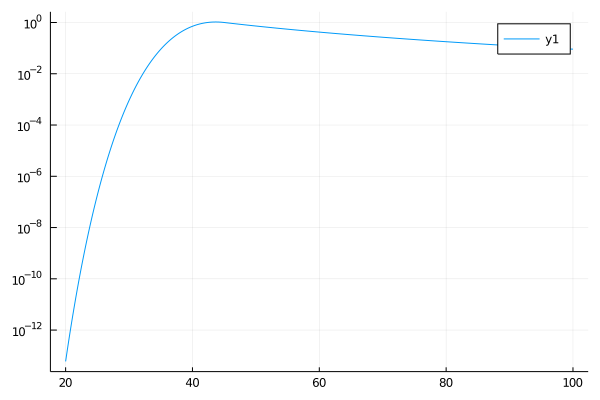

In [15]:
m = 20.0:0.01:100.0
plot(m, exp.(PISNMassFunctions.log_dNdm1dq_highmass.(m, 1.0, 3.0, 0.0, 45.0)), yscale=:log10)

Ultimately, the primary mass distribution looks something like the below:

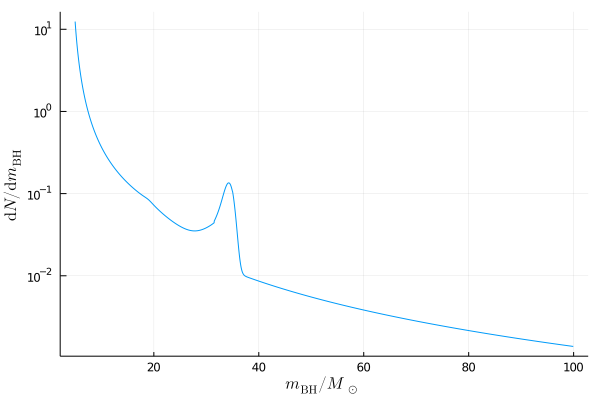

In [16]:
let mbhs = exp.(log(5.0):0.001:log(100.0)), a = 1.35, b = 2.35, beta=-0.5, beta_c = 0.0, mBH_max = 35.0, mPISN = 0.9*mBH_max, f = 0.1, c = 2.0, sigma = 1.0
    log_ref_amp, log_norm = PISNMassFunctions.log_dNdm1dq_ref_amplitudes.(a, b, beta, mPISN, mBH_max, sigma, f, c, beta_c)
    plot(mbhs, exp.(PISNMassFunctions.log_dNdm1dq.(mbhs, 1.0, a, b, beta, mPISN, mBH_max, sigma, f, c, beta_c, log_ref_amp, log_norm)), yscale=:log10, legend=nothing)
    xlabel!(L"m_\mathrm{BH}/M_\odot")
    ylabel!(L"\mathrm{d} N / \mathrm{d} m_\mathrm{BH}")
end

Fits to O3a coming soon!